In [1]:
cd ..

/scratch/rd804/m-anode


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from src.nflow_utils import *
import os
from src.utils import *
from src.nflow_utils import *
from src.generate_data_lhc import *
from src.utils import *
from src.flows import *

from nflows import transforms, distributions, flows
import torch
import torch.nn.functional as F
from nflows.distributions import uniform
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, ShuffleSplit
import argparse
import pickle
import wandb
import sys


In [3]:


parser = argparse.ArgumentParser()
parser.add_argument('--n_sig',type=int , default=50000, help='signal train')
parser.add_argument('--mode_background', type=str, default='freeze', help='train, freeze, pretrained')


parser.add_argument('--epochs', type=int, default=2, help='epochs')
parser.add_argument('--batch_size', type=int, default = 256, help = 'batch size')
parser.add_argument('--mini_batch', type=int, default= 256, help='mini batch size')
parser.add_argument('--gpu', type=str, default='cuda:0', help='gpu to train on')
parser.add_argument('--data_loss_expr', type=str, default='true_likelihood', help='loss for SR region')


parser.add_argument('--resample', action='store_true', help='if data is to resampled')
parser.add_argument('--seed', type=int, default=11, help='seed')
parser.add_argument('--shuffle_split', action='store_true', help='if shuffle split is used')
parser.add_argument('--split', type=int, default=1, help='split number')
parser.add_argument('--data_dir', type=str, default='data/lhc_co', help='data directory')
parser.add_argument('--config_file', type=str, default='scripts/DE_MAF_model.yml', help='config file')
parser.add_argument('--S_config_file', type=str, default='scripts/DE_MAF_model.yml', help='config file')

parser.add_argument('--CR_path', type=str, default='results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0', help='CR data path')
parser.add_argument('--ensemble', action='store_true',default = True ,help='if ensemble is used')

parser.add_argument('--wandb', action='store_true', help='if wandb is used' )
parser.add_argument('--wandb_group', type=str, default='debugging_r_anode')
parser.add_argument('--wandb_job_type', type=str, default='lhc_co')
parser.add_argument('--wandb_run_name', type=str, default='try_10')
parser.add_argument('--include_samples', action='store_true', help='if samples are included')


args = parser.parse_args(args=[])

In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt


In [5]:
data_dir = "data/lhc_co"
nsig=1000
x_test = np.load(f'{data_dir}/x_test.npy')
label = x_test[:,-1]
true_signal = x_test[label == 1]
true_background = x_test[label == 0]
bins = np.linspace(0.0,1.0,100)
true_w = 0.006

#log_prob_S = {}
#log_prob_B = {}
#data_histogram = {}

In [6]:
for try_ in range(10):
    data_histogram[try_] = {}
    log_prob_S[try_] = {}
    log_prob_B[try_] = {}
    
    with open(f'figures/sample_dict_SR_mass_{nsig}_{try_}.pkl', 'rb') as f:
        samples = pickle.load(f)
    with open(f'figures/log_prob_dict_SR_mass_{nsig}_{try_}.pkl', 'rb') as f:
        logprobs = pickle.load(f)
    

    weights = []

    for key in samples['SR'].keys():
      #  hist = np.array(samples['SR'][key])
    #  print(samples['SR'][key].shape)
        weight_value = float(key.split('_')[0])
        weights.append(weight_value)
        hist = np.array(samples['SR'][key])
        hist_data = [np.histogram(hist[:,i], bins = bins, density = True)[0] for i in range(4)]
        hist_data = np.array(hist_data)
        data_histogram[try_][weight_value] = hist_data
        log_prob_S[try_][weight_value] = logprobs['S'][key]
        log_prob_B[try_][weight_value] = logprobs['B'][key]



/home/rd804/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [6]:
from scipy.stats import rv_histogram

mass = np.load(f'{data_dir}/true_mass.npy')
labels = np.load(f'{data_dir}/true_labels.npy')

bins = np.linspace(3.3, 3.7, 50)
hist_sig = np.histogram(mass[labels==1], bins=bins, density=True)
mass_density_sig = rv_histogram(hist_sig)

hist_back = np.histogram(mass[labels==0], bins=bins, density=True)
mass_density_back = rv_histogram(hist_back)

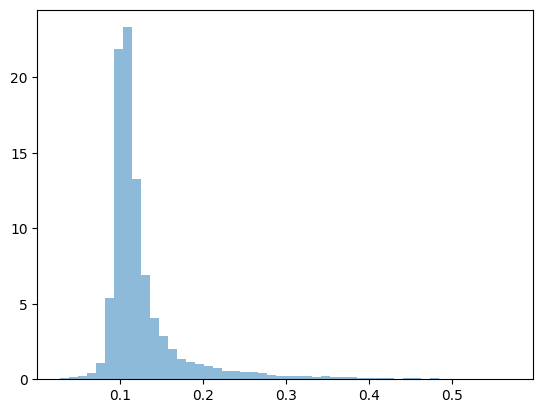

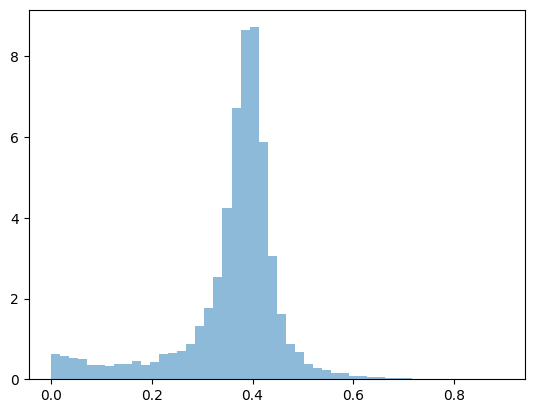

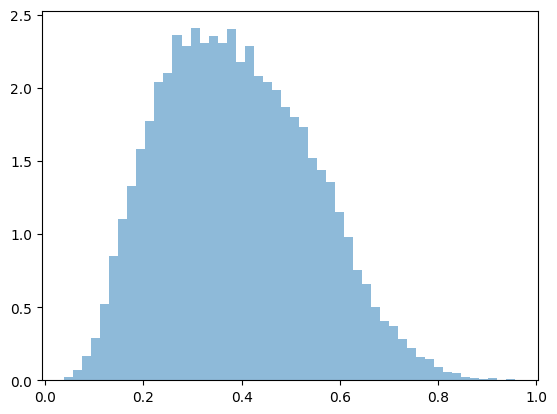

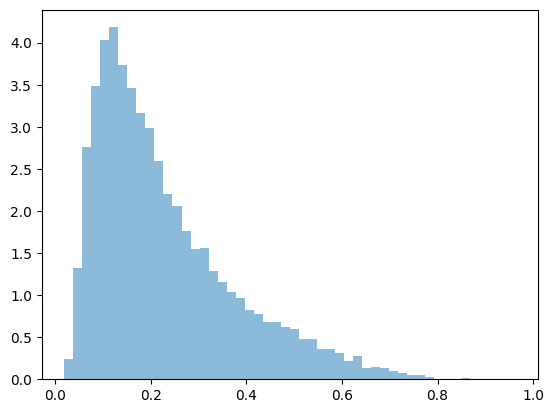

In [7]:
marginalized_densities_S = {}
for i in range(4):
    plt.hist(x_test[:,i+1][x_test[:,-1]==1], bins = 50, density = True, alpha = 0.5, label = 'signal')
    plt.show()

    hist = np.histogram(x_test[:,i+1][x_test[:,-1]==1], bins = 50, density = True)
    density = rv_histogram(hist)
    marginalized_densities_S[i] = density


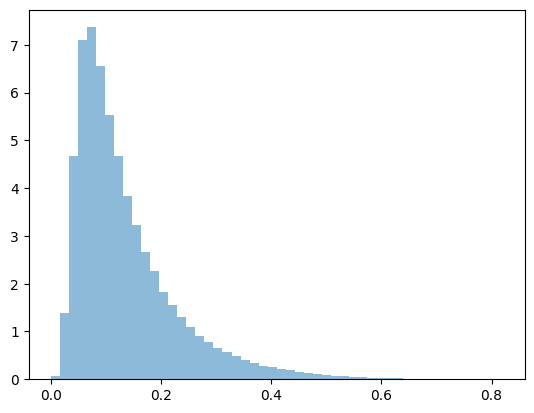

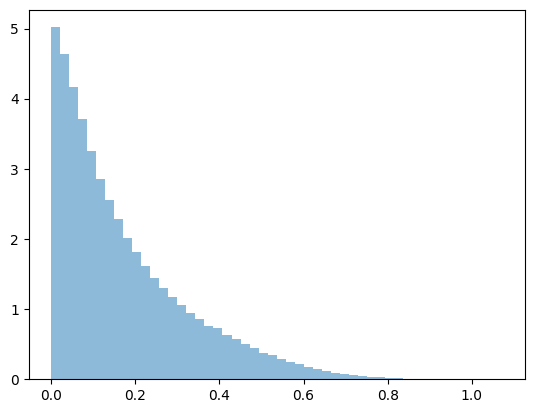

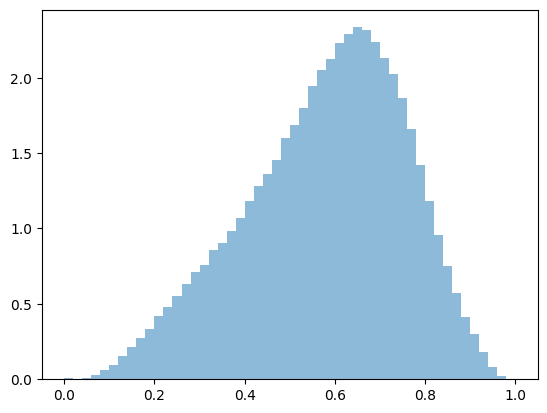

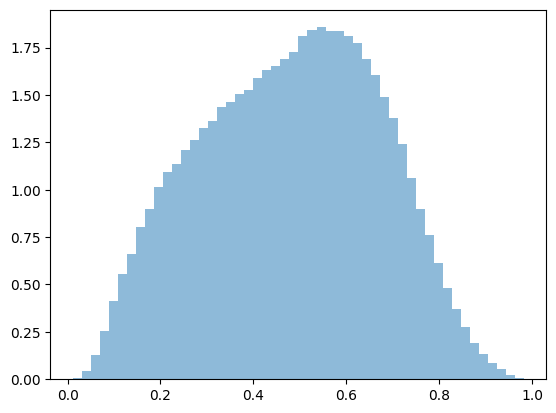

In [8]:
marginalized_densities_B = {}
for i in range(4):
    plt.hist(x_test[:,i+1][x_test[:,-1]==0], bins = 50, density = True, alpha = 0.5, label = 'signal')
    plt.show()

    hist = np.histogram(x_test[:,i+1][x_test[:,-1]==0], bins = 50, density = True)
    density = rv_histogram(hist)
    marginalized_densities_B[i] = density


In [ ]:

# average over the 10 tries
data_histogram_mean = {}
data_histogram_std = {}
for key in data_histogram[0].keys():
    data_histogram_mean[key] = {}
    data_histogram_std[key] = {}

    for i in range(4):
        data_histogram_mean[key][i] = np.mean([data_histogram[try_][key][i] for try_ in range(10)], axis = 0)
        data_histogram_std[key][i] = np.std([data_histogram[try_][key][i] for try_ in range(10)], axis = 0)

#############################
#############################
# true mass P_sig(x|m)
with open(f'figures/sample_dict_SR_mass_true_m_{nsig}_0.pkl', 'rb') as f:
        samples = pickle.load(f)

samples = samples['SR'][f'{true_w}_{nsig}']
hist = np.array(samples)
hist_data = [np.histogram(hist[:,i], bins = bins, density = True)[0] for i in range(4)]
hist_data = np.array(hist_data)
data_histogram_mean['mass'] = {}
data_histogram_std['mass'] = {}
for i in range(4):
    data_histogram_mean['mass'][i] = hist_data[i]
    data_histogram_std['mass'][i] = np.zeros_like(hist_data[i])

##########################################
##########################################

# plot the histograms
fig, ax = plt.subplots(2,2, figsize = (16,8))
ax = ax.flatten()
for feature in range(4):
  ax[feature].hist(true_signal[:,feature+1], bins = bins, density = True, label = 'data', color='black', alpha = 0.5)
  for weight in data_histogram_mean.keys():
    if weight == true_w:
      ax[feature].step(bins[:-1], data_histogram_mean[weight][feature], label = f'true_w={weight}')
    else:
      ax[feature].step(bins[:-1], data_histogram_mean[weight][feature], label = weight)

    if weight != 'mass':
      ax[feature].fill_between(bins[:-1], data_histogram_mean[weight][feature] - data_histogram_std[weight][feature], data_histogram_mean[weight][feature] + data_histogram_std[weight][feature], step='pre', alpha = 0.3)
    ax[feature].set_title(f'Feature {feature}')
    ax[feature].legend()
  #  ax[feature].set_xlabel('Feature value')
    ax[feature].set_ylabel('Density')

# save the figure
plt.savefig(f'figures/sample_plots_SR_mass_with_mass_{nsig}.png')  



In [9]:
q_s_x = data_histogram[1][0.006]

NameError: name 'data_histogram' is not defined

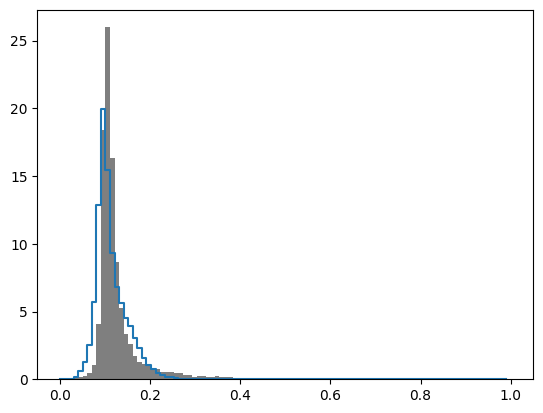

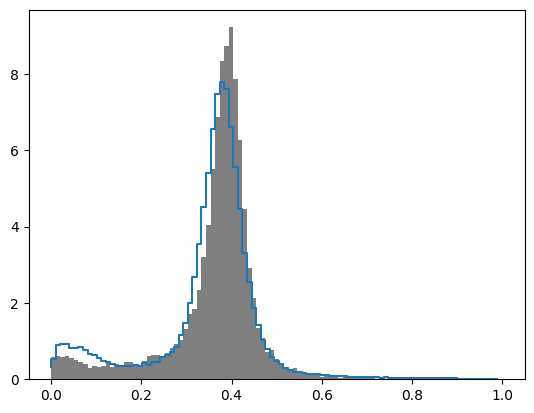

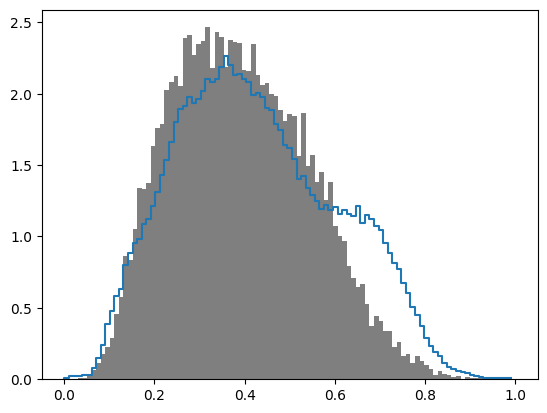

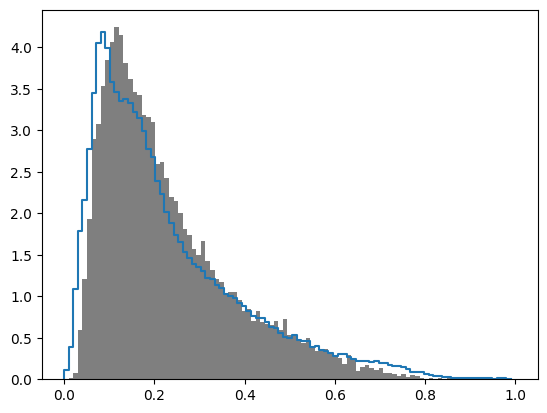

In [22]:
for i in range(0,4,1):
    plt.step(bins[:-1], q_s_x[i], label = 'q_s_x')
    plt.hist(true_signal[:,i+1], bins = bins, density = True, label = 'data', color='black', alpha = 0.5)
    plt.show()

In [10]:
with open(f'figures/sample_dict_SR_mass_{nsig}_{0}.pkl', 'rb') as f:
    samples_0 = pickle.load(f)

samples_0 = samples_0['SR'][f'{true_w}_{nsig}']

In [15]:
with open(f'figures/sample_dict_SR_mass_true_m_1000_0.pkl', 'rb') as f:
    samples_0_mass = pickle.load(f)

samples_0_mass = samples_0_mass['SR'][f'{true_w}_{nsig}']

In [16]:
samples_0_mass.shape

(200000, 5)

In [9]:
log_prob_S_0 = log_prob_S[0][true_w]
log_prob_B_0 = log_prob_B[0][true_w]

In [24]:
def R_m(m, density_sig, density_back):
    return np.exp(density_sig.logpdf(m) - density_back.logpdf(m))

/tmp/ipykernel_691/3727821646.py:2: RuntimeWarning: invalid value encountered in subtract
  return np.exp(density_sig.logpdf(m) - density_back.logpdf(m))


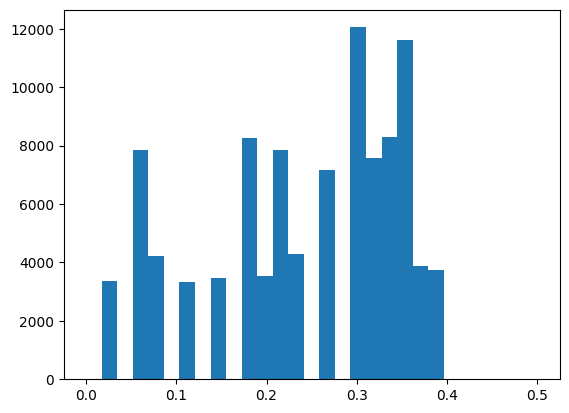

In [28]:
bins = np.linspace(0, 0.5, 30)
R_m_0 = R_m(samples_0[:,0], density_sig, density_back)
plt.hist((R_m_0-1)/R_m_0, bins = bins, density = False)
plt.show()

In [10]:
def p_s_x(samples,log_prob_B,log_prob_S,m_density_S,m_density_B):
    mass = samples[:,0]
    R = m_density_S.pdf(mass)/(m_density_B.pdf(mass))

    p_b_x = np.exp(log_prob_B).flatten()
    q_s_x = np.exp(log_prob_S).flatten()

    # 1 = R*(p_s_x/q_s_x) + (1-R)*(p_b_x/q_s_x)
    # reweight = p_s_x/q_s_x
    reweighting = 1/R - ((1-R)/R)*(p_b_x/q_s_x)

    return reweighting


In [76]:
def q_s_x(samples,density_x_S,density_x_B,m_density_S,m_density_B):
    mass = samples[:,0]
    R = m_density_S.pdf(mass)/(m_density_B.pdf(mass)+1e-32)

   # p_b_x = np.exp(log_prob_B).flatten()
   # q_s_x = np.exp(log_prob_S).flatten()
    qs={}
    reweight={}
    term1 = {}
    term2 = {}
    term3 = {}
    for i in range(4):
        p_s_x = density_x_S[i].pdf(samples[:,i+1])
        p_b_x = density_x_B[i].pdf(samples[:,i+1])

        qs[i+1] = R*p_s_x + (1-R)*p_b_x
        reweight[i+1] = (qs[i+1])/(p_s_x+1e-32)
        term1[i+1] = R
        term2[i+1] = (1-R)*p_b_x/(p_s_x+1e-32)
        term3[i+1] = p_s_x/(p_s_x+1e-32)


    
    # 1 = R*(p_s_x/q_s_x) + (1-R)*(p_b_x/q_s_x)
    # reweight = p_s_x/q_s_x
   # reweighting = 1/R - ((1-R)/R)*(p_b_x/q_s_x)

    return qs, reweight, term1, term2

In [77]:
qsx_test, reweight_test, term1, term2 = q_s_x(x_test,marginalized_densities_S,marginalized_densities_B,mass_density_sig,mass_density_back)

In [74]:
qsx, reweight = q_s_x(samples_0,marginalized_densities_S,marginalized_densities_B,mass_density_sig,mass_density_back)

In [75]:
weights = reweight_test[1][x_test[:,-1]==1]
reweight = weights[(weights<5) & (weights>0)]

x_test_1 = x_test[x_test[:,-1]==1]
x_test_1 = x_test_1[(weights<5) & (weights>0)]

print(len(weights))
print(len(reweight))
print(len(x_test_1))


20000
19659
19659


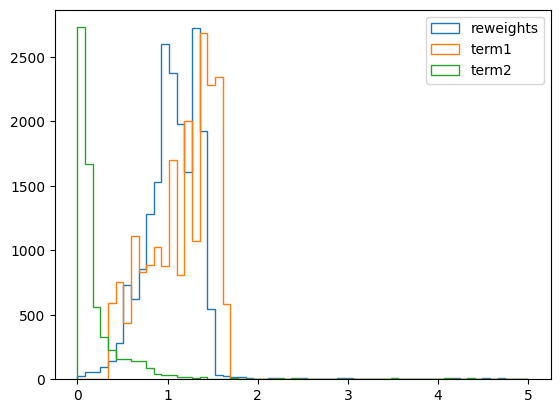

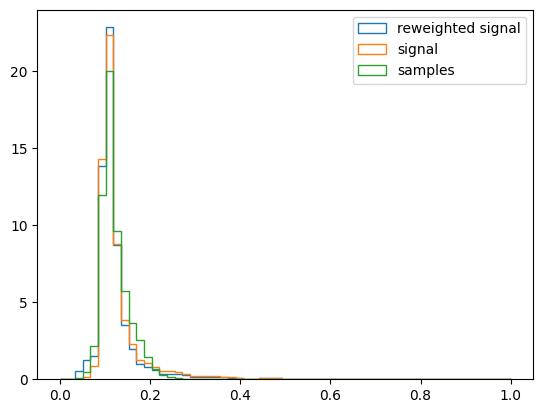

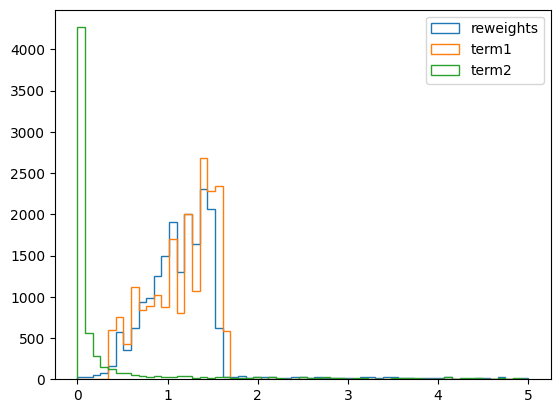

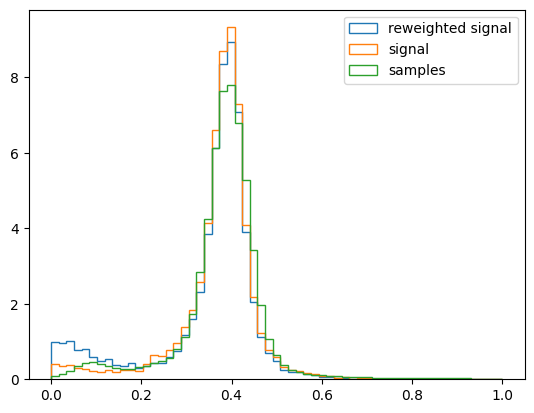

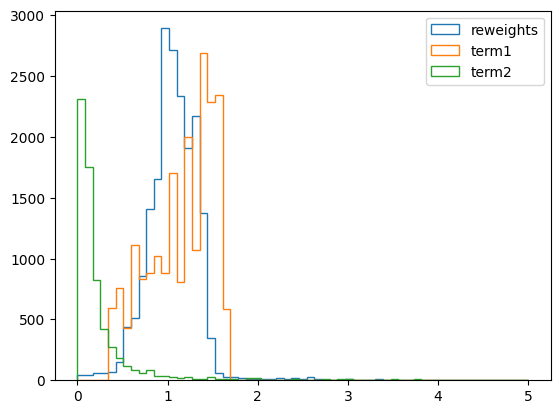

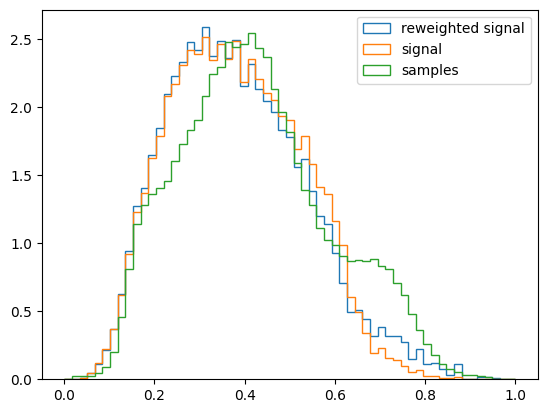

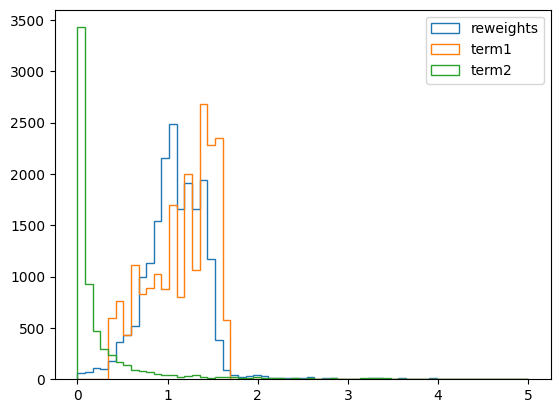

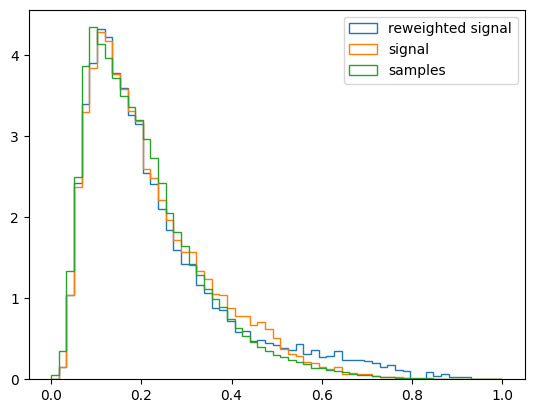

In [80]:
#bins=np.linspace(-1,1,50)
for i in range(1,5,1):
    bins = np.linspace(0,1,60)
    weights = reweight_test[i][x_test[:,-1]==1]
    reweight = weights[(weights<20) & (weights>0)]
    bins2 = np.linspace(0,5,60)
    plt.hist(reweight, bins=bins2, histtype='step', label='reweights')
    plt.hist(term1[i][x_test[:,-1]==1], bins=bins2, histtype='step', label='term1')
    plt.hist(term2[i][x_test[:,-1]==1], bins=bins2, histtype='step', label='term2')
    plt.legend()
    plt.show()

    x_test_1 = x_test[x_test[:,-1]==1]
    x_test_1 = x_test_1[(weights<20) & (weights>0)]

    plt.hist(x_test_1[:,i], bins=bins,weights = reweight, histtype='step', density=True, label='reweighted signal')
    plt.hist(x_test_1[:,i], bins=bins, histtype='step', density=True, label='signal')
    plt.hist(samples_0[:,i], bins=bins, histtype='step', density=True, label='samples')
    plt.legend()
    plt.show()

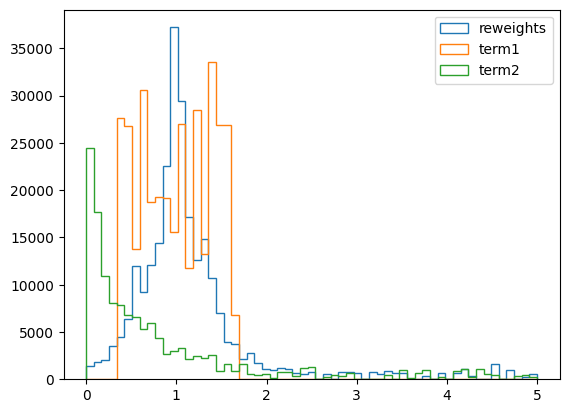

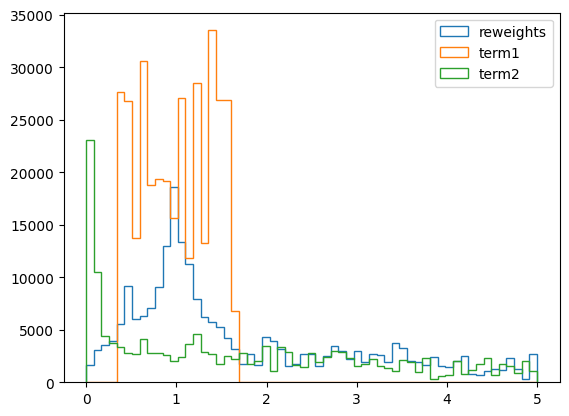

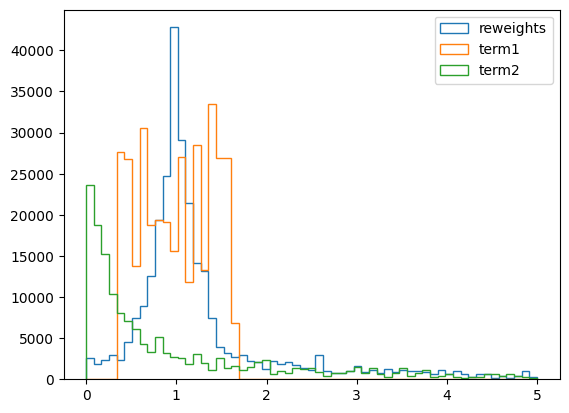

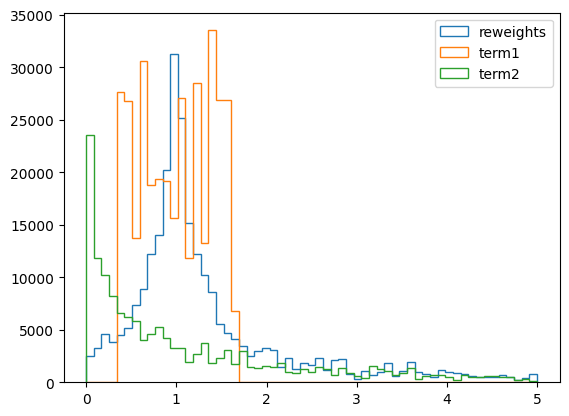

In [81]:
#bins=np.linspace(-1,1,50)
for i in range(1,5,1):
    bins = np.linspace(0,1,60)
    weights = reweight_test[i][x_test[:,-1]==0]
    reweight = weights[(weights<20) & (weights>0)]
    bins2 = np.linspace(0,5,60)
    plt.hist(reweight, bins=bins2, histtype='step', label='reweights')
    plt.hist(term1[i][x_test[:,-1]==0], bins=bins2, histtype='step', label='term1')
    plt.hist(term2[i][x_test[:,-1]==0], bins=bins2, histtype='step', label='term2')
    plt.legend()
    plt.show()

  #  x_test_1 = x_test[x_test[:,-1]==1]
  #  x_test_1 = x_test_1[(weights<20) & (weights>0)]

  #  plt.hist(x_test_1[:,i], bins=bins,weights = reweight, histtype='step', density=True, label='reweighted signal')
  #  plt.hist(x_test_1[:,i], bins=bins, histtype='step', density=True, label='signal')
  #  plt.hist(samples_0[:,i], bins=bins, histtype='step', density=True, label='samples')
  #  plt.legend()
  #  plt.show()

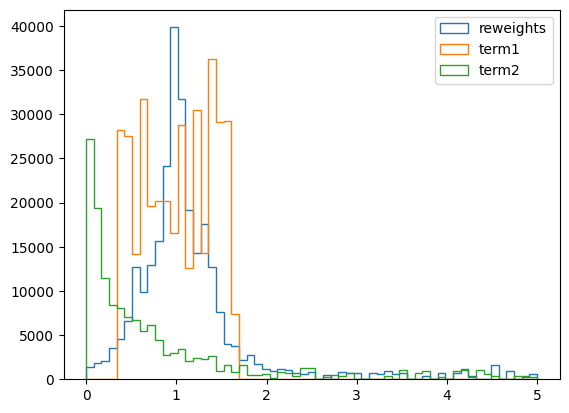

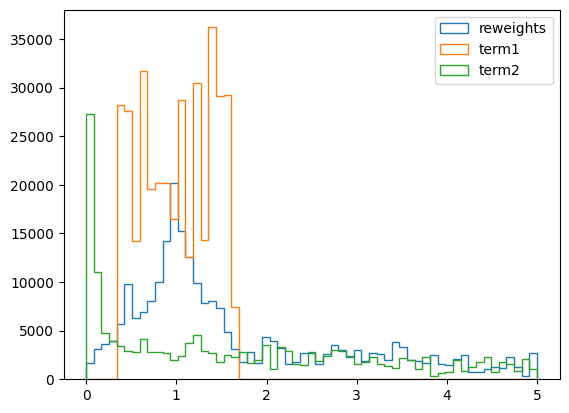

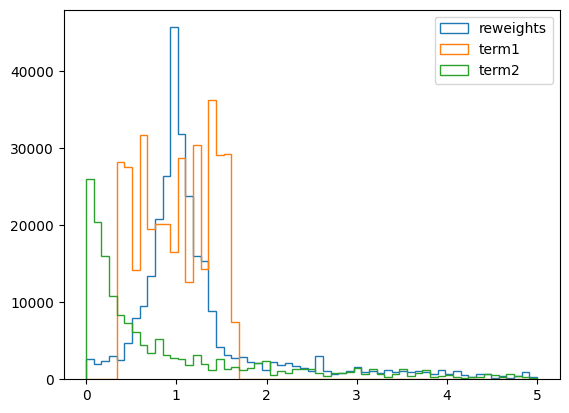

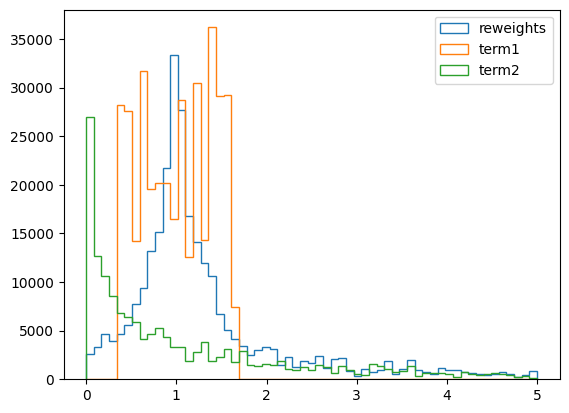

In [82]:
for i in range(1,5,1):
    bins = np.linspace(0,1,60)
    weights = reweight_test[i]
    reweight = weights[(weights<20) & (weights>0)]
    bins2 = np.linspace(0,5,60)
    plt.hist(reweight, bins=bins2, histtype='step', label='reweights')
    plt.hist(term1[i], bins=bins2, histtype='step', label='term1')
    plt.hist(term2[i], bins=bins2, histtype='step', label='term2')
    plt.legend()
    plt.show()

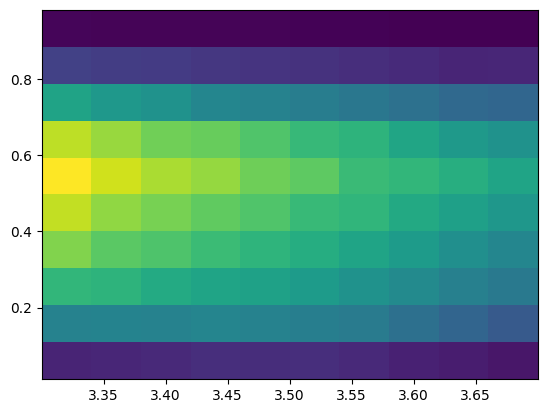

In [19]:
plt.hist2d(x_test[:,0],x_test[:,4], bins = 10, density = True)
plt.show()

0.3795846838159818


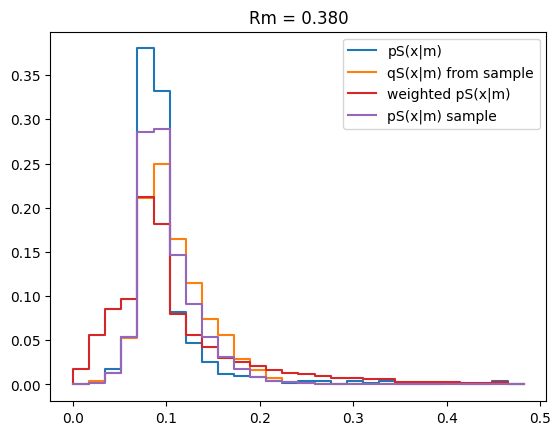

0.5090893920253944


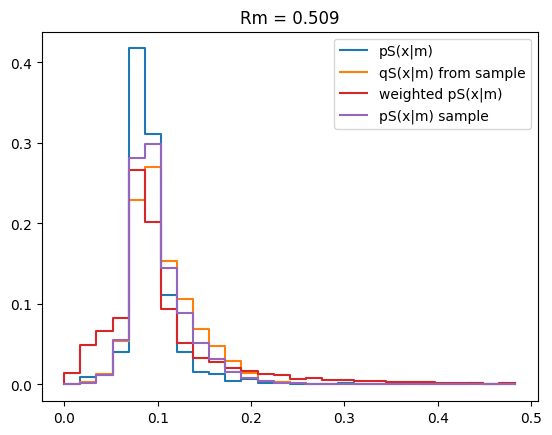

0.6485493795172509


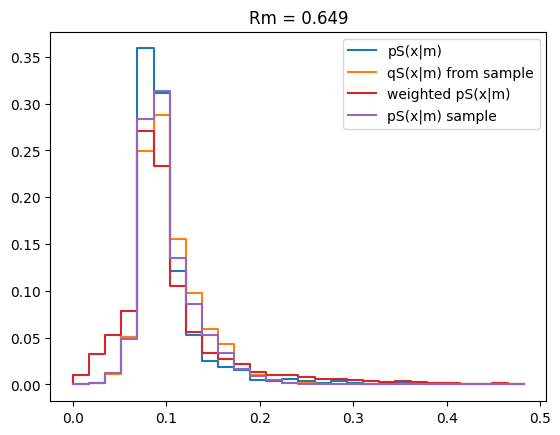

0.881496


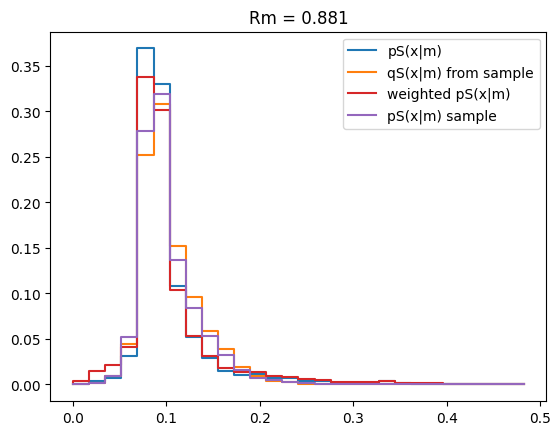

1.0947291666666668


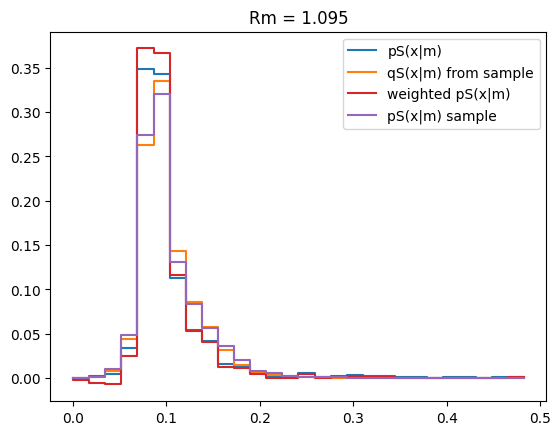

1.2841109237166284


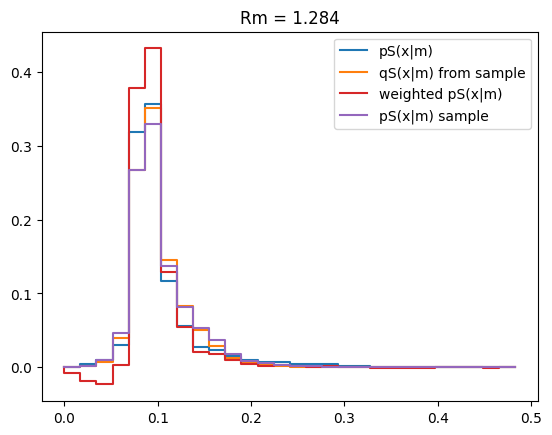

1.373286089238845


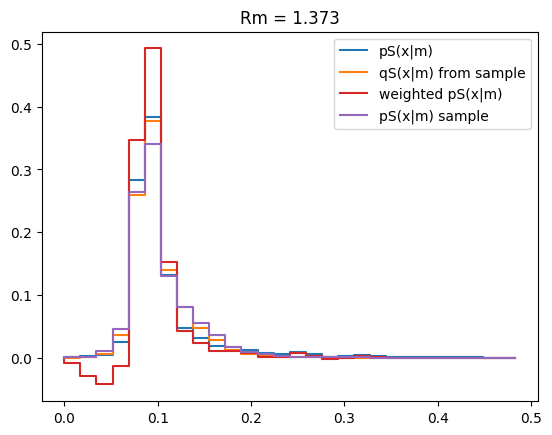

1.519899137425676


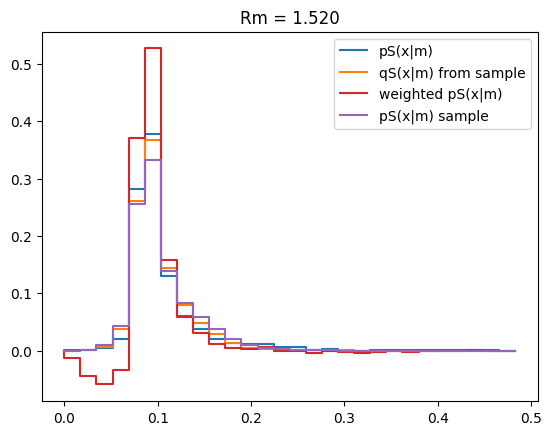

1.4836800000000003


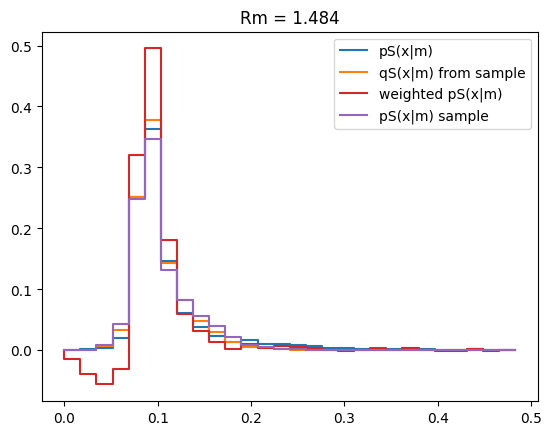

1.4406855993048886


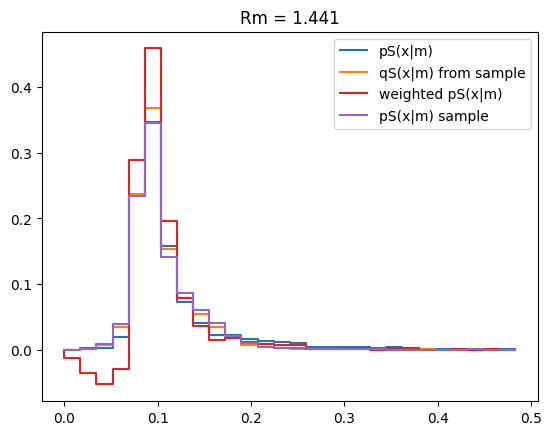

1.2436950894556529


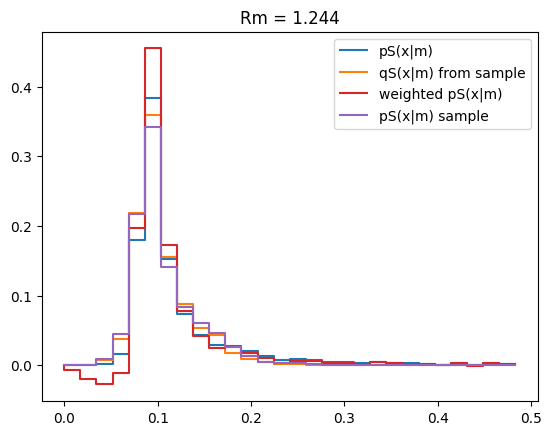

1.0555990313812702


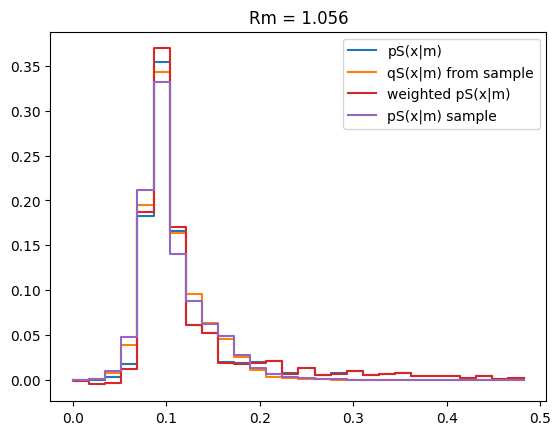

0.8348363825147959


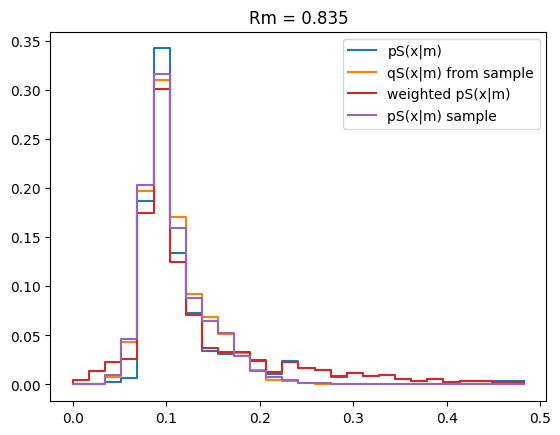

0.6318325982638702


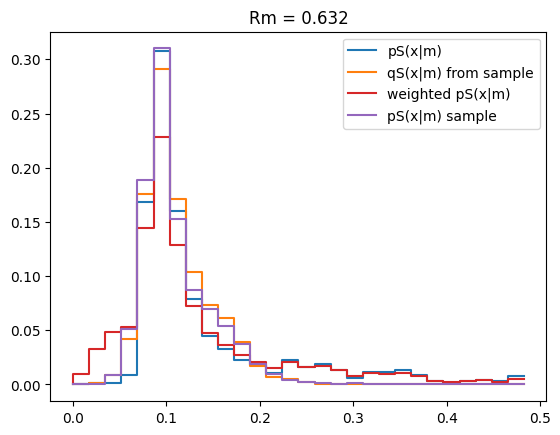

In [26]:
import matplotlib.backends.backend_pdf

plot_feature=1
pdf = matplotlib.backends.backend_pdf.PdfPages(f"./figures/conditional_{plot_feature}.pdf")

for mbin in range(14):

    for feature in [plot_feature]:

        label = x_test[:,-1]
        mass_bins = np.linspace(3.3,3.7,15)
        feature_bins = np.linspace(0,0.5,30)
        mass_bin = mbin

        mass_s, xbins_s = np.histogram(x_test[:,0][label==1], bins = mass_bins, density = True)
        mass_b, xbins_b = np.histogram(x_test[:,0][label==0], bins = mass_bins, density = True)

        R_m = mass_s/mass_b
        print(R_m[mass_bin])

        probs_s, xbins_s, ybins_s = np.histogram2d(x_test[:,0][label==1],x_test[:,feature][label==1],
                                            bins = (mass_bins,feature_bins), density = True)

        probs_b, xbins_b, ybins_b = np.histogram2d(x_test[:,0][label==0],x_test[:,feature][label==0],
                                                bins = (mass_bins,feature_bins), density = True)

        probs_q, xbins_q, ybins_q = np.histogram2d(samples_0[:,0],samples_0[:,feature], 
                                                bins = (mass_bins,feature_bins), density = True)
        
        prob_true_m, xbins_true_m, ybins_true_m = np.histogram2d(samples_0_mass[:,0],samples_0_mass[:,feature], 
                                                bins = (mass_bins,feature_bins), density = True)
        

       # probs_s = np.clip(probs_s, a_min = 1e-32, a_max = None)
       # probs_q = np.clip(probs_q, a_min = 1e-32, a_max = None)
       # probs_b = np.clip(probs_b, a_min = 1e-32, a_max = None)

        ps_x_m = probs_s[mass_bin,:]/np.sum(probs_s[mass_bin,:])
        qs_x_m = probs_q[mass_bin,:]/np.sum(probs_q[mass_bin,:])
        pb_x_m = probs_b[mass_bin,:]/np.sum(probs_b[mass_bin,:])
        prob_true_m = prob_true_m[mass_bin,:]/np.sum(prob_true_m[mass_bin,:])

        weighted_p_x_m = R_m[mass_bin]*ps_x_m + (1-R_m[mass_bin])*pb_x_m
        weighted_q_x_m = qs_x_m/R_m[mass_bin] - (1-R_m[mass_bin])*pb_x_m/R_m[mass_bin]


        plt.step(ybins_s[:-1], probs_s[mass_bin,:]/np.sum(probs_s[mass_bin,:]), label = 'pS(x|m)')
        plt.step(ybins_q[:-1], probs_q[mass_bin,:]/np.sum(probs_q[mass_bin,:]), label = 'qS(x|m) from sample')
     #   plt.step(ybins_b[:-1], probs_b[mass_bin,:]/np.sum(probs_b[mass_bin,:]), label = 'pB(x|m)')
        plt.step(ybins_q[:-1], weighted_p_x_m, label = 'weighted pS(x|m)', color='C3')
        plt.step(ybins_true_m[:-1], prob_true_m, label = 'pS(x|m) sample', color='C4')
      #  plt.step(ybins_q[:-1], weighted_q_x_m, label = 'weighted qS(x|m)')
        plt.title('Rm = %.3f' % (R_m[mass_bin]))
        plt.legend()
        pdf.savefig()
        plt.show()
pdf.close()

array([3.3       , 3.34444444, 3.38888889, 3.43333333, 3.47777778,
       3.52222222, 3.56666667, 3.61111111, 3.65555556, 3.7       ])

In [11]:
_p_s_x = p_s_x(samples_0,log_prob_B_0,log_prob_S_0,density_sig,density_back) 

/tmp/ipykernel_691/2804508065.py:3: RuntimeWarning: invalid value encountered in true_divide
  R = m_density_S.pdf(mass)/(m_density_B.pdf(mass))


In [12]:
_p_s_x = np.nan_to_num(_p_s_x, nan=0.0, posinf=0.0, neginf=0.0)
_p_s_x = np.clip(_p_s_x, a_min=0.0, a_max=None)

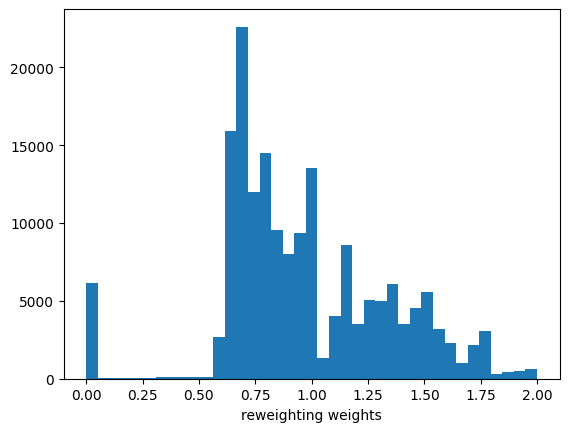

In [39]:
bins = np.linspace(0.0,2.0,40)
plt.hist(_p_s_x, bins = bins, density = False)
plt.xlabel('reweighting weights')
plt.show()

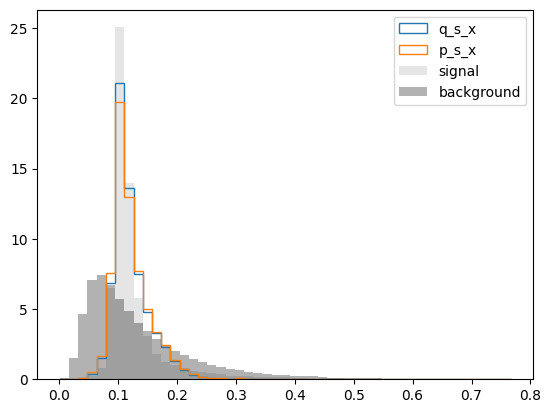

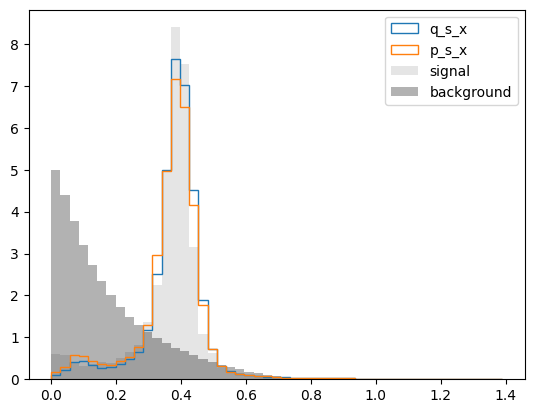

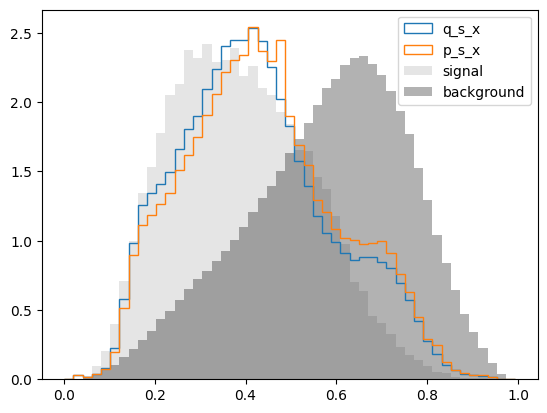

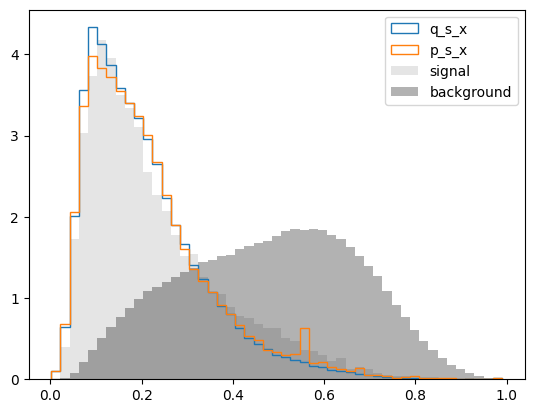

In [38]:
for i in range(4):
    max_value = np.amax(samples_0[:,i+1])
    min_value = np.amin(samples_0[:,i+1])
    bins = np.linspace(min_value,max_value,50)

    plt.hist(samples_0[:,i+1],bins=bins, density=True,histtype='step', label = 'q_s_x')
    plt.hist(samples_0[:,i+1],bins=bins, density=True, weights = _p_s_x, histtype='step', label = 'p_s_x')
    plt.hist(true_signal[:,i+1],bins=bins, density=True, label = 'signal',alpha = 0.2, color='gray')
    plt.hist(true_background[:,i+1],bins=bins, density=True, label = 'background', alpha = 0.3, color='black')
    plt.legend()
    plt.show()

In [6]:
import numpy as np

In [8]:
wandb_group_ranode_mass = "nflows_lhc_co_nsig_scan"
wandb_project_ranode_mass = "ra_mass_joint_un_clip"
wandb_job_type_ranode_mass = "try"

wandb_group_wscan = "nflows_lhc_co_w_scan"
#wandb_project_wscan = f"ra_mass_{nsig}"
wandb_project_wscan = f"ra_mass_joint_1000"
wandb_job_type_wscan = "try"

In [4]:
cd ..

/scratch/rd804/m-anode


In [9]:
pwd

'/scratch/rd804/m-anode'

In [7]:
weights = [0.0001,0.001,'true_w',0.01,0.1]
color = ['C0','C1','C2','C3','C4']
true_w = 0.006


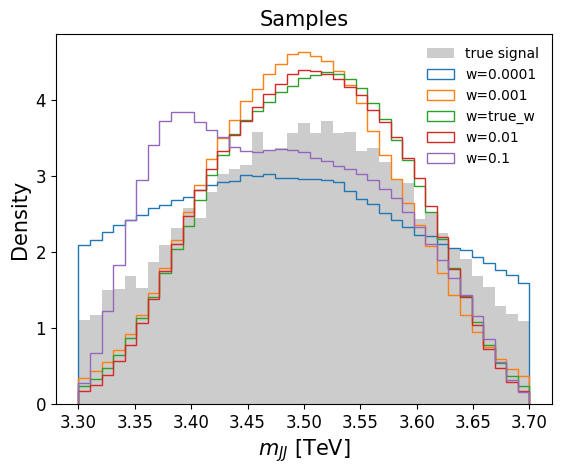

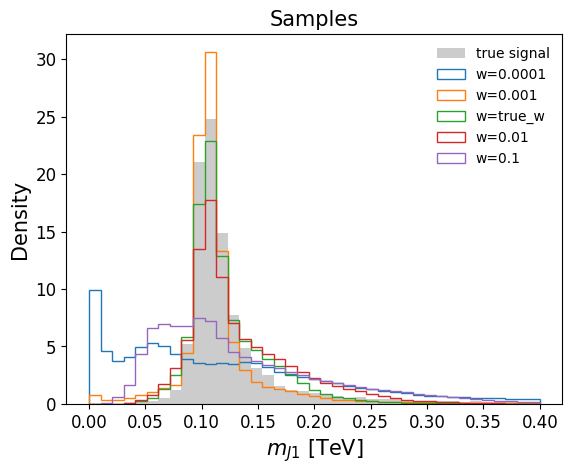

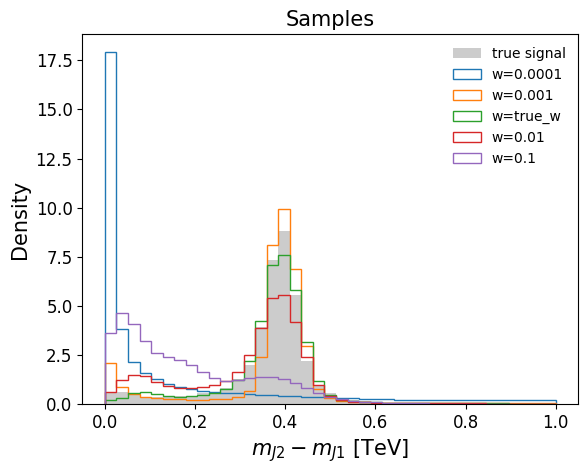

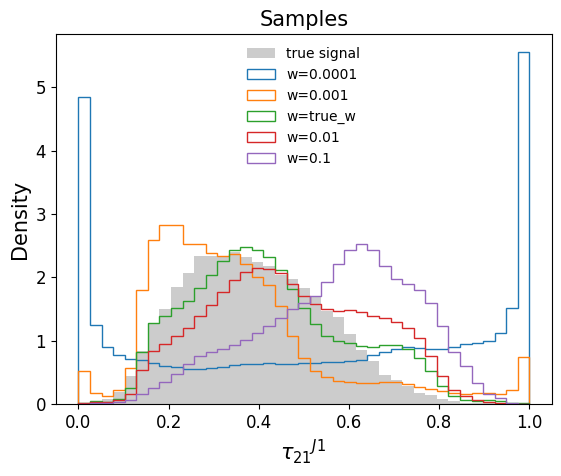

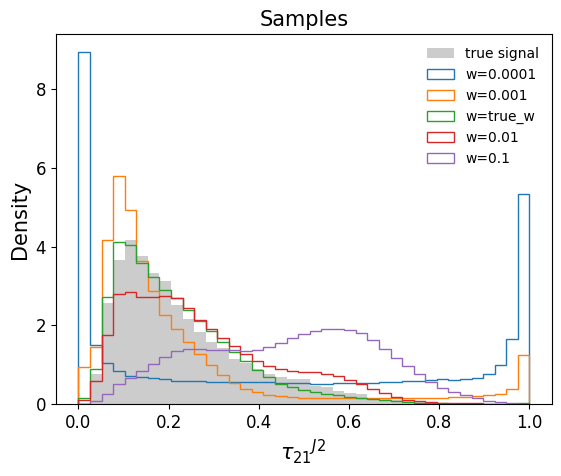

In [18]:
from matplotlib import pyplot as plt
#for feature in range(5):
for feature in [0,1,2,3,4]:

    #for nsig in [1000,300,150]:
    for w_ in weights:
        if w_ == 'true_w':
            directory = f'results/{wandb_group_ranode_mass}/{wandb_project_ranode_mass}_{nsig}/{wandb_job_type_ranode_mass}_0_'
        else:
            directory = f'results/{wandb_group_wscan}/{wandb_project_wscan}_{w_}/{wandb_job_type_wscan}_0_'

        ensembled_samples =[]

        for i in range(20):
            samples = np.load(f'{directory}{i}/samples.npy')[:,feature]
            ensembled_samples.append(samples)

        ensembled_samples = np.array(ensembled_samples)
        ensembled_samples = ensembled_samples.flatten()

        data_dir = "data/lhc_co"
        x_test = np.load(f'{data_dir}/x_test.npy')
        label = x_test[:,-1]
        if feature == 0:
            bins = np.linspace(3.3,3.7,40)
            plt.xlabel(r'$m_{JJ}$ [TeV]',fontsize=15)
        elif feature == 1:
            bins = np.linspace(0.0,0.4,40)
            ensembled_samples-=3.5
            plt.xlabel(r'$m_{J1}$ [TeV]',fontsize=15)
        elif feature == 3:
            bins = np.linspace(0.0,1.0,40)
            ensembled_samples-=3.5
            plt.xlabel(r'${\tau_{21}}^{J1}}$ ',fontsize=15)
        elif feature == 2:
            bins = np.linspace(0.0,1.0,40)
            ensembled_samples-=3.5
            plt.xlabel(r'$m_{J2} - m_{J1}$ [TeV]',fontsize=15)
        elif feature == 4:
            bins = np.linspace(0.0,1.0,40)
            ensembled_samples-=3.5
            plt.xlabel(r'${\tau_{21}}^{J2}}$ ',fontsize=15)

        if w_ == 0.0001:
            plt.hist(x_test[:,feature][label==1], bins = bins, density = True, histtype='stepfilled', label = 'true signal',color='black', alpha = 0.2)
       # plt.hist(ensembled_samples, bins = bins, density = True, histtype='step', label = f'Nsig={nsig}')
              # plt.hist(ensembled_samples, bins = bins, density = True, histtype='step', label = f'Nsig={nsig}')
        plt.hist(ensembled_samples, bins = bins, density = True, histtype='step', label = f'w={w_}')

        plt.legend(frameon=False)
    plt.ylabel('Density',fontsize=15)
    plt.title('Samples',fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f'figures/presentation/samples_wscan_joint_{feature}.pdf',dpi=200,bbox_inches='tight')

    #plt.savefig(f'figures/presentation/mass_samples_{feature}.pdf',dpi=200,bbox_inches='tight')
    plt.show()



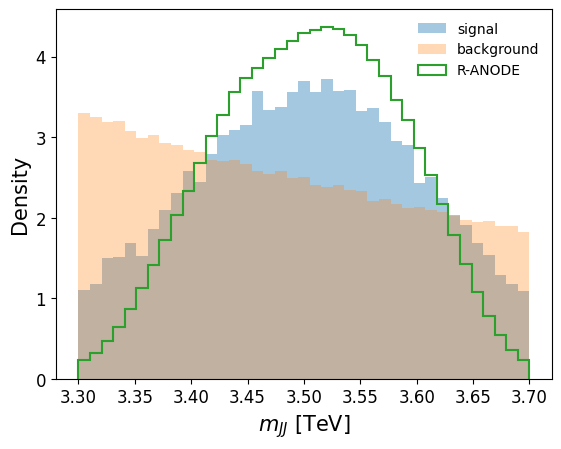

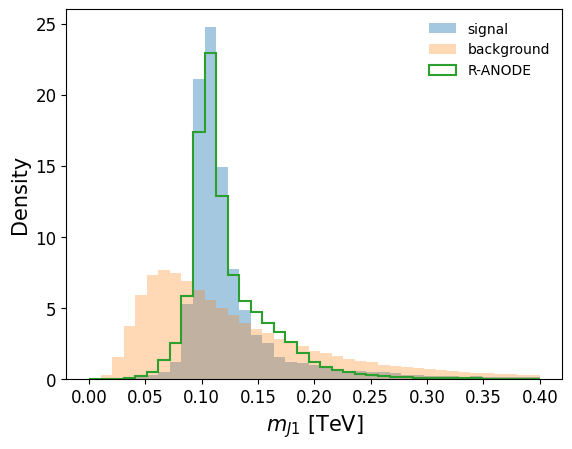

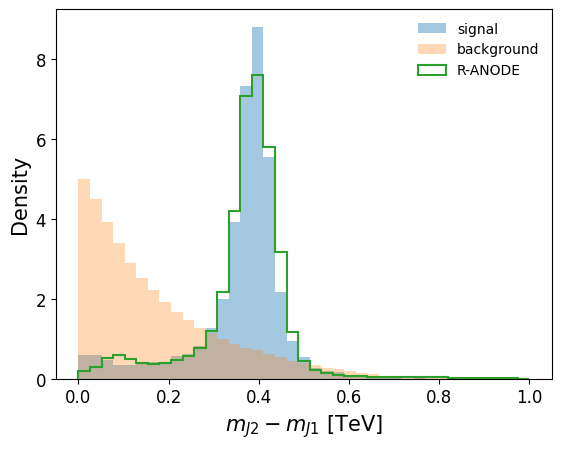

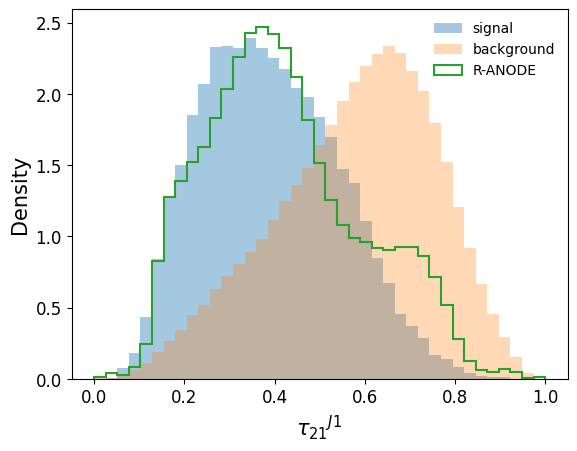

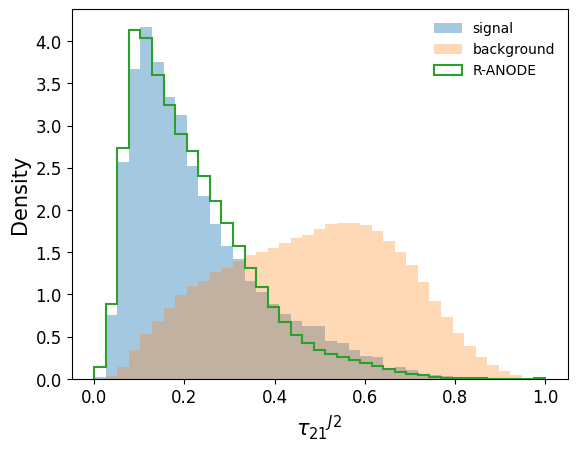

In [16]:
from matplotlib import pyplot as plt
#for feature in range(5):
for feature in [0,1,2,3,4]:

    #for nsig in [1000,300,150]:
    for nsig in [1000]:
        directory = f'results/{wandb_group_ranode_mass}/{wandb_project_ranode_mass}_{nsig}/{wandb_job_type_ranode_mass}_0_'

        ensembled_samples =[]

        for i in range(20):
            samples = np.load(f'{directory}{i}/samples.npy')[:,feature]
            ensembled_samples.append(samples)

        ensembled_samples = np.array(ensembled_samples)
        ensembled_samples = ensembled_samples.flatten()

        data_dir = "data/lhc_co"
        x_test = np.load(f'{data_dir}/x_test.npy')
        label = x_test[:,-1]
        if feature == 0:
            bins = np.linspace(3.3,3.7,40)
            plt.xlabel(r'$m_{JJ}$ [TeV]',fontsize=15)
        elif feature == 1:
            bins = np.linspace(0.0,0.4,40)
            ensembled_samples-=3.5
            plt.xlabel(r'$m_{J1}$ [TeV]',fontsize=15)
        elif feature == 3:
            bins = np.linspace(0.0,1.0,40)
            ensembled_samples-=3.5
            plt.xlabel(r'${\tau_{21}}^{J1}}$ ',fontsize=15)
        elif feature == 2:
            bins = np.linspace(0.0,1.0,40)
            ensembled_samples-=3.5
            plt.xlabel(r'$m_{J2} - m_{J1}$ [TeV]',fontsize=15)
        elif feature == 4:
            bins = np.linspace(0.0,1.0,40)
            ensembled_samples-=3.5
            plt.xlabel(r'${\tau_{21}}^{J2}}$ ',fontsize=15)

        if nsig == 1000:
            plt.hist(x_test[:,feature][label==1], bins = bins, density = True, histtype='stepfilled', label = 'signal',color='C0', alpha = 0.4)
            plt.hist(x_test[:,feature][label==0], bins = bins, density = True, histtype='stepfilled', label = 'background',color='C1', alpha = 0.3)
           # plt.hist(ensembled_samples, bins = bins, density = True, histtype='step', label = f'Nsig={nsig}',color='C3')
        #else:
           # plt.hist(ensembled_samples, bins = bins, density = True, histtype='step', label = f'Nsig={nsig}',color='C2')
        
        plt.hist(ensembled_samples, bins = bins, density = True, histtype='step', label = 'R-ANODE',lw=1.5,color='C2')

             #  plt.hist(ensembled_samples, bins = bins, density = True, histtype='step', label = f'Nsig={nsig}')
      #  plt.hist(ensembled_samples, bins = bins, density = True, histtype='step', label = 'samples')

        plt.legend(frameon=False)
    plt.ylabel('Density',fontsize=15)
    #plt.title('Samples',fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.savefig(f'figures/presentation/david_samples_{feature}.pdf',dpi=200,bbox_inches='tight')
    plt.show()



In [7]:
pwd

'/scratch/rd804/m-anode'

In [6]:
import numpy as np

In [7]:
import pickle

with open(f'figures/sample_dict_SR_mass_true_m_1000_0.pkl', 'rb') as f:
       samples = pickle.load(f)

In [16]:
sample_1 = samples['SR']['0.006_1000']

(2000000,)
(2000000,)
(2000000,)


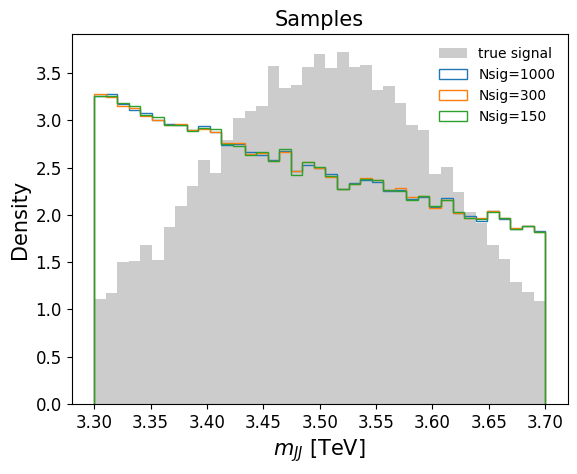

(2000000,)
(2000000,)
(2000000,)


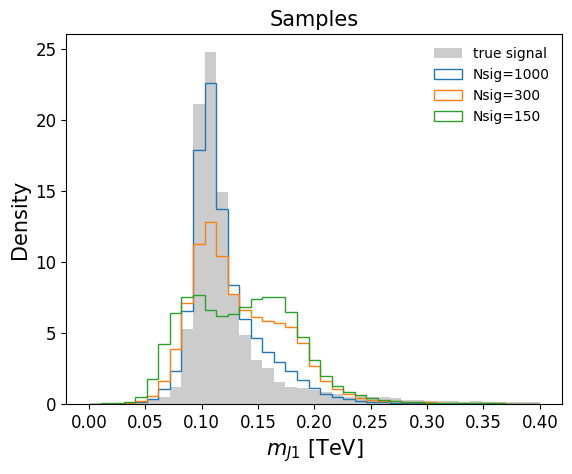

(2000000,)
(2000000,)
(2000000,)


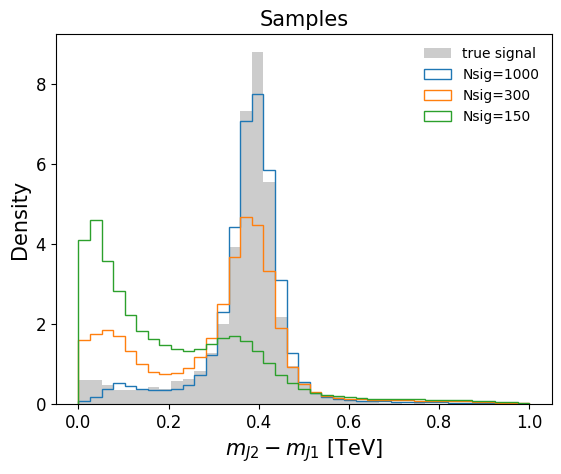

(2000000,)
(2000000,)
(2000000,)


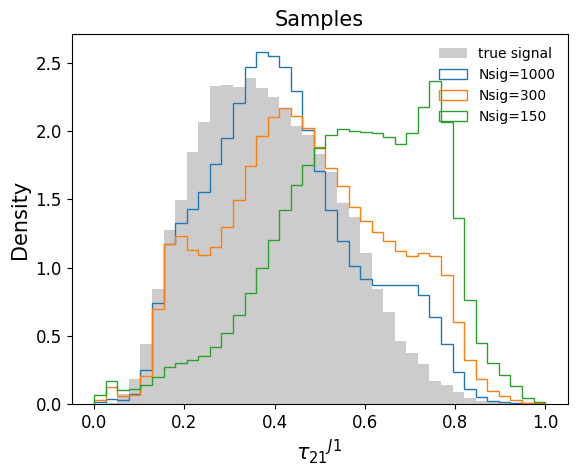

(2000000,)
(2000000,)
(2000000,)


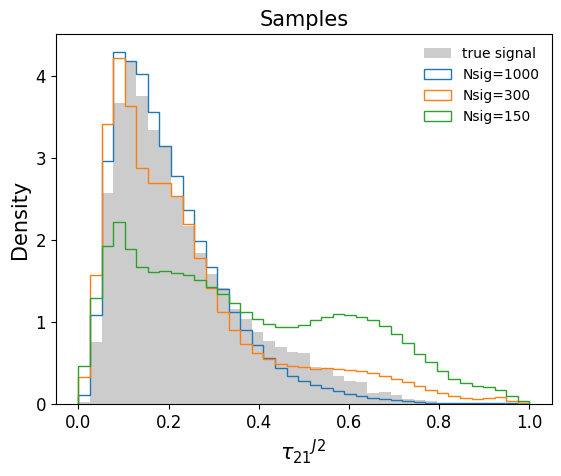

In [6]:
data_dir = "data/lhc_co"
x_test = np.load(f'{data_dir}/x_test.npy')
label = x_test[:,-1]

for feature in range(5):
    #for key in samples['SR'].keys():
       # nsig = int(key.split('_')[1])
       # nsig = int(key)
      #  print(nsig)
    for nsig in [1000,300,150]:
            ensembled_samples = np.load(f'./figures/samples_{nsig}.npy')[:,feature]
            #ensembled_samples = samples['SR'][key][:,feature]
            print(ensembled_samples.shape)
        
            if feature == 0:
                bins = np.linspace(3.3,3.7,40)
                plt.xlabel(r'$m_{JJ}$ [TeV]',fontsize=15)
            elif feature == 1:
                bins = np.linspace(0.0,0.4,40)
                plt.xlabel(r'$m_{J1}$ [TeV]',fontsize=15)
            elif feature == 3:
                bins = np.linspace(0.0,1.0,40)
                plt.xlabel(r'${\tau_{21}}^{J1}}$ ',fontsize=15)
            elif feature == 2:
                bins = np.linspace(0.0,1.0,40)
                plt.xlabel(r'$m_{J2} - m_{J1}$ [TeV]',fontsize=15)
            elif feature == 4:
                bins = np.linspace(0.0,1.0,40)
                plt.xlabel(r'${\tau_{21}}^{J2}}$ ',fontsize=15)

            if nsig == 1000:
                plt.hist(x_test[:,feature][label==1], bins = bins, density = True, histtype='stepfilled', label = 'true signal',color='black', alpha = 0.2)
            plt.hist(ensembled_samples, bins = bins, density = True, histtype='step', label = f'Nsig={nsig}')
           # plt.legend()
        
    plt.legend(loc='upper right',frameon=False)
    plt.ylabel('Density',fontsize=15)
    plt.title('Samples',fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.savefig(f'figures/presentation/ensemble_samples_conditional_{feature}.pdf',dpi=200,bbox_inches='tight')
    plt.show()

   # else:
      #  continue

    

